# Data Preprocessing - Hand Gesture Recognition

**Student Project - Intro to AI**

This notebook loads collected images, applies augmentation, and prepares data for training.

## 1. Import Libraries

In [1]:
import cv2
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pickle
from collections import Counter

## 2. Settings

In [2]:
# Directories
raw_dir = '../data/raw'
processed_dir = '../data/processed'

# Parameters
image_size = (64, 64)  # Resize all images to 64x64
test_size = 0.2  # 20% for testing, 80% for training

# Gestures
gestures = ['fist', 'open_palm', 'pointing_finger', 'thumbs_up', 'peace_sign']

## 3. Load Images

Load all collected images from the raw data directory.

In [3]:
print("Loading images...")
print("="*60)

# Lists to store images and labels
all_images = []
all_labels = []

# Load images from each gesture folder
for gesture in gestures:
    folder = os.path.join(raw_dir, gesture)
    image_files = [f for f in os.listdir(folder) if f.endswith('.jpg')]
    
    print(f"{gesture}: {len(image_files)} images")
    
    for img_file in image_files:
        img_path = os.path.join(folder, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        
        if img is not None:
            all_images.append(img)
            all_labels.append(gesture)

print(f"\nTotal images loaded: {len(all_images)}")
print("="*60)

Loading images...
fist: 600 images
open_palm: 600 images
pointing_finger: 600 images
thumbs_up: 600 images
peace_sign: 600 images

Total images loaded: 3000


## 4. Data Augmentation

Create more training images from existing ones using:
- Horizontal flip
- Rotation (±15°)
- Brightness adjustment

This helps the model generalize better and prevents overfitting.

In [4]:
print("\nApplying data augmentation...")

augmented_images = []
augmented_labels = []

for img, label in zip(all_images, all_labels):
    # Original image
    augmented_images.append(img)
    augmented_labels.append(label)
    
    # Flipped image (horizontal flip)
    flipped = cv2.flip(img, 1)
    augmented_images.append(flipped)
    augmented_labels.append(label)
    
    # Rotated images (+15 and -15 degrees)
    rows, cols = img.shape
    for angle in [-15, 15]:
        M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
        rotated = cv2.warpAffine(img, M, (cols, rows))
        augmented_images.append(rotated)
        augmented_labels.append(label)
    
    # Brightness variations
    bright = cv2.convertScaleAbs(img, alpha=1.2, beta=10)  # Brighter
    dark = cv2.convertScaleAbs(img, alpha=0.8, beta=-10)  # Darker
    augmented_images.append(bright)
    augmented_labels.append(label)
    augmented_images.append(dark)
    augmented_labels.append(label)

print(f"Original: {len(all_images)} images")
print(f"After augmentation: {len(augmented_images)} images")
print(f"Expansion factor: {len(augmented_images) / len(all_images):.1f}x")


Applying data augmentation...
Original: 3000 images
After augmentation: 18000 images
Expansion factor: 6.0x


## 5. Preprocess Images

Resize and normalize all images.

In [5]:
print("\nPreprocessing images...")

processed_images = []
for img in augmented_images:
    # Resize to 64x64
    resized = cv2.resize(img, image_size)
    
    # Normalize to 0-1 range (helps neural network learn better)
    normalized = resized.astype('float32') / 255.0
    
    processed_images.append(normalized)

# Convert to numpy array
X = np.array(processed_images)
X = X.reshape(-1, image_size[0], image_size[1], 1)  # Add channel dimension

print(f"Final shape: {X.shape}")
print(f"Data type: {X.dtype}")
print(f"Value range: [{X.min():.2f}, {X.max():.2f}]")


Preprocessing images...
Final shape: (18000, 64, 64, 1)
Data type: float32
Value range: [0.00, 1.00]


## 6. Encode Labels

Convert gesture names (text) to numbers for training.

In [6]:
# Encode labels (convert text to numbers)
# Example: fist -> 0, open_palm -> 1, etc.
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(augmented_labels)

print("\nLabel encoding:")
for i, gesture in enumerate(label_encoder.classes_):
    print(f"  {gesture} -> {i}")


Label encoding:
  fist -> 0
  open_palm -> 1
  peace_sign -> 2
  pointing_finger -> 3
  thumbs_up -> 4


## 7. Train-Test Split

Split data into 80% training and 20% testing sets.

In [7]:
print("\nSplitting data...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_size,
    random_state=42,
    stratify=y  # Keep same proportion of each class
)

print(f"Training set: {len(X_train)} images")
print(f"Testing set: {len(X_test)} images")
print(f"Train/Test ratio: {len(X_train)/len(X_test):.1f}:1")


Splitting data...
Training set: 14400 images
Testing set: 3600 images
Train/Test ratio: 4.0:1


## 8. Save Processed Data

In [8]:
print("\nSaving processed data...")
os.makedirs(processed_dir, exist_ok=True)

np.save(os.path.join(processed_dir, 'X_train.npy'), X_train)
np.save(os.path.join(processed_dir, 'X_test.npy'), X_test)
np.save(os.path.join(processed_dir, 'y_train.npy'), y_train)
np.save(os.path.join(processed_dir, 'y_test.npy'), y_test)

# Save label encoder (to convert numbers back to names later)
with open(os.path.join(processed_dir, 'label_encoder.pkl'), 'wb') as f:
    pickle.dump(label_encoder, f)

print("Saved!")


Saving processed data...
Saved!


## 9. Visualize Sample Images

Sample images saved


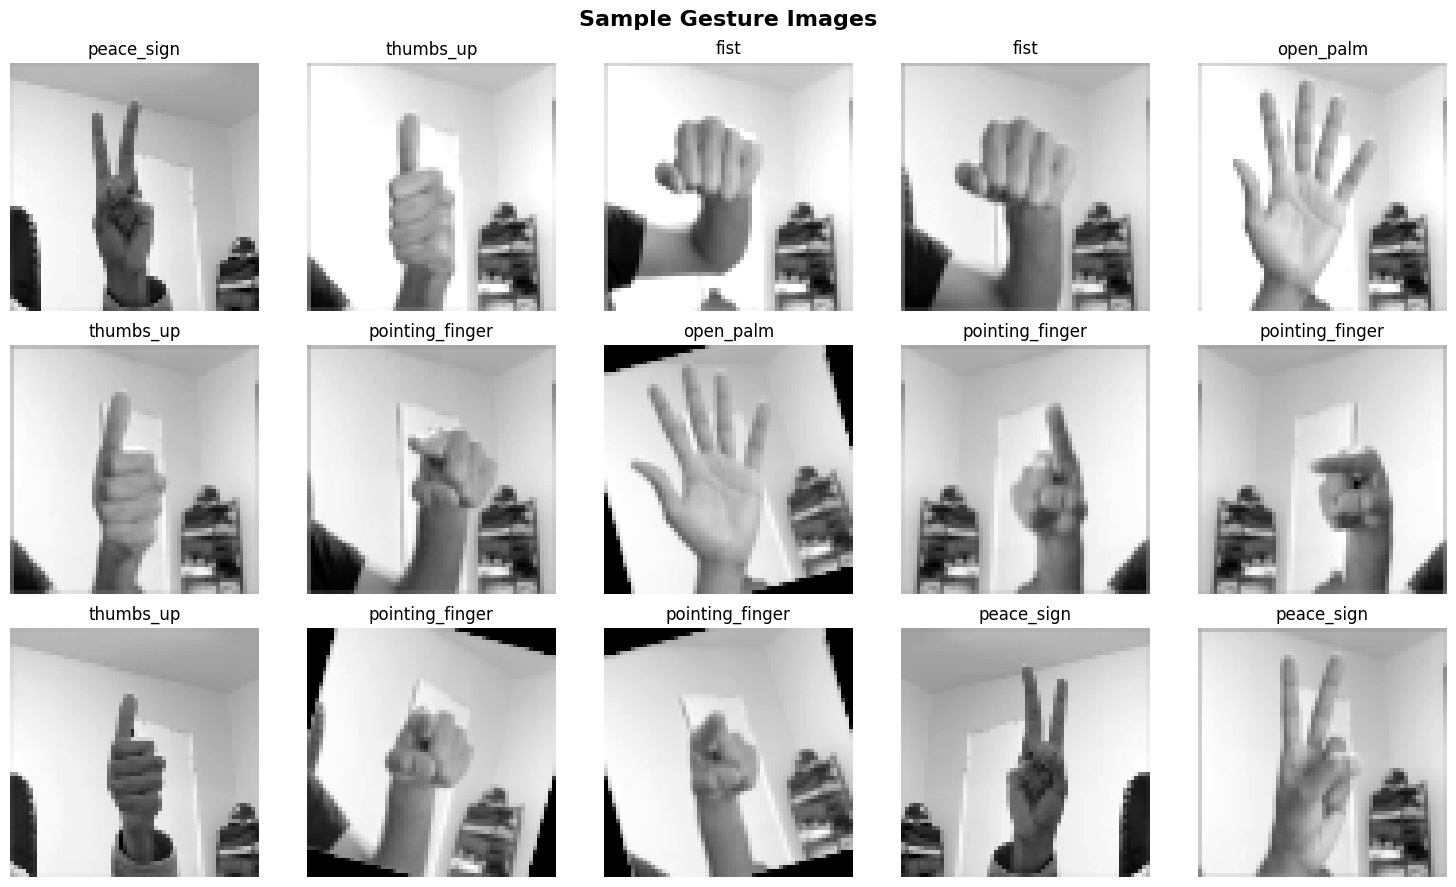

In [12]:
# Sample images
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
fig.suptitle('Sample Gesture Images', fontsize=16, fontweight='bold')

indices = np.random.choice(len(X_test), 15, replace=False)
for i, ax in enumerate(axes.flat):
    idx = indices[i]
    img = X_test[idx].squeeze()
    label = label_encoder.inverse_transform([y_test[idx]])[0]
    
    ax.imshow(img, cmap='gray')
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(processed_dir, 'sample_images.png'))
print("Sample images saved")
plt.show()

## 10. Visualize Class Distribution

Class distribution saved


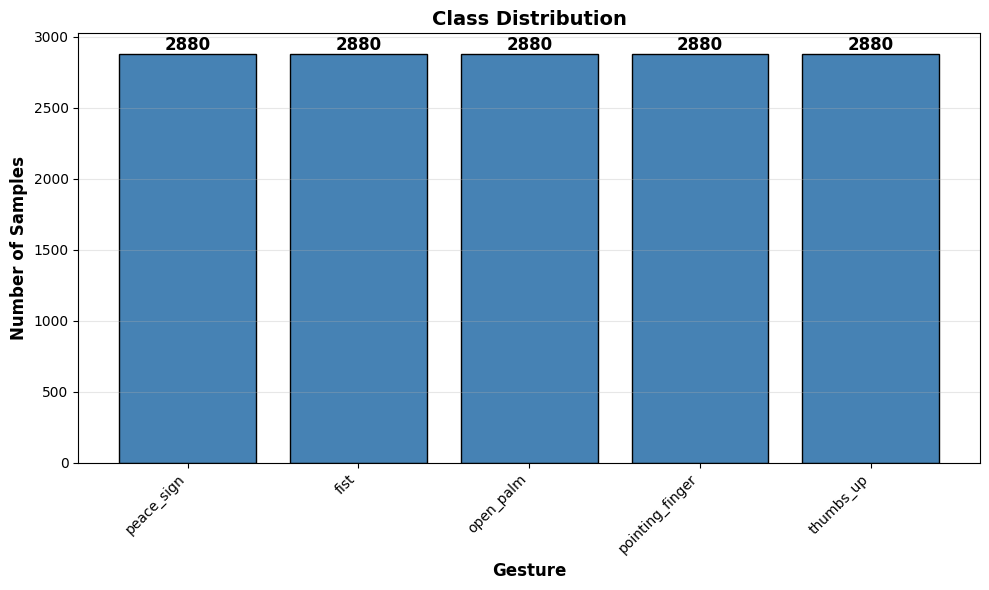

In [10]:
# Class distribution
label_counts = Counter([label_encoder.inverse_transform([l])[0] for l in y_train])

plt.figure(figsize=(10, 6))
gestures_list = list(label_counts.keys())
counts = list(label_counts.values())

bars = plt.bar(gestures_list, counts, color='steelblue', edgecolor='black')

# Add numbers on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xlabel('Gesture', fontsize=12, fontweight='bold')
plt.ylabel('Number of Samples', fontsize=12, fontweight='bold')
plt.title('Class Distribution', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(processed_dir, 'class_distribution.png'))
print("Class distribution saved")
plt.show()

## 11. Summary

In [11]:
print("\n" + "="*60)
print("PREPROCESSING COMPLETE!")
print("="*60)
print("\nFiles saved:")
print("  - X_train.npy, X_test.npy (images)")
print("  - y_train.npy, y_test.npy (labels)")
print("  - label_encoder.pkl (for predictions)")
print("  - sample_images.png")
print("  - class_distribution.png")
print("="*60)



PREPROCESSING COMPLETE!

Files saved:
  - X_train.npy, X_test.npy (images)
  - y_train.npy, y_test.npy (labels)
  - label_encoder.pkl (for predictions)
  - sample_images.png
  - class_distribution.png
